In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from scipy.stats import sem, ttest_ind
from datetime import datetime, date, timedelta

In [2]:
import numpy as np
import statistics
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

In [10]:
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a22d9d860>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [12]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a22da92b0>,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

Exploratory Climate Analysis

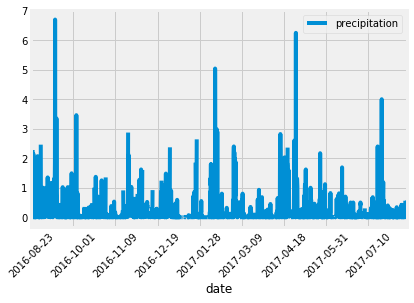

In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

precipitation = session.query(Measurement.date,Measurement.prcp).\
    filter((Measurement.date) >= query_date).all()

# Calculate the date 1 year ago from the last data point in the database
    
# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(precipitation, columns=["date","precipitation"])
df.set_index(["date"],inplace = True)

# Sort the dataframe by date
df = df.sort_index()
df


# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=45)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(Station.station).count()
print("There are {} stations".format(stations))

There are 9 stations


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, (func.count(Measurement.id))).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(
    (func.min(Measurement.tobs)),
    (func.max(Measurement.tobs)),
    (func.avg(Measurement.tobs))).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

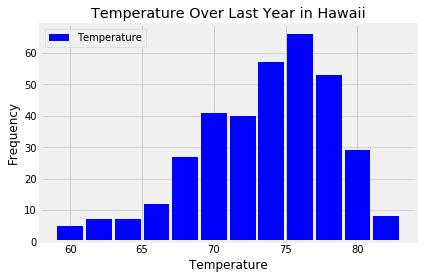

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(Measurement.station, (func.count(Measurement.tobs))).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

Temp_last_year = session.query(Measurement.date,Measurement.tobs).\
    filter((Measurement.date) >= query_date).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
Temps_df = pd.DataFrame(Temp_last_year, columns=["date","Temperature"])

# plot the results as a histogram
Temps_df.plot.hist(grid=True, bins=12, rwidth=0.9,
                   color='blue')
plt.title('Temperature Over Last Year in Hawaii')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Temperature Analysis I

In [19]:
hawaii_stations_df = pd.read_csv("Resources/hawaii_stations.csv")
hawaii_stations_df.head()

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [20]:
hawaii_measurements_df = pd.read_csv("Resources/hawaii_measurements.csv")
hawaii_measurements_df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [21]:
# Average temp in June from stations in all year reported
date_str = "06"
june_temps = session.query(Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == date_str).all()

june_avg_temps = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == date_str).all()
june_avg_temps

[(74.94411764705882)]

In [22]:
# Average temp in December from stations in all year reported
date_str = "12"
december_temps = session.query(Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == date_str).all()
december_temps

december_avg_temps = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == date_str).all()
december_avg_temps

[(71.04152933421226)]

In [23]:
# t-test
(t_stat, p) = ttest_ind(june_temps, december_temps, equal_var=False)

if p < 0.05:
    print("The differences between the June and December temperature are significant.")
else:
    print("The differences between June and December temperature are NOT significant.")

The differences between the June and December temperature are significant.


I am using a paired t-test because we are sampling from the same sample area (Hawaii) from 2 independent time points (June and December)

# Temperature Analysis II

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
start_date = '2017-04-18'
end_date = '2017-04-25'

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(f"Vacation start date was {start_date} and ended on {end_date}")
print(f"min temp, avg temp, max temp")
print(calc_temps(start_date, end_date))

Vacation start date was 2017-04-18 and ended on 2017-04-25
min temp, avg temp, max temp
[(67.0, 74.0, 83.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date_object = datetime.strptime(start_date, '%Y-%m-%d').date()

previous_year_start_date = start_date_object - timedelta(365)
#previous_year_start_date

end_date_object = datetime.strptime(end_date, '%Y-%m-%d').date()

previous_year_end_date = end_date_object - timedelta(365)
#previous_year_end_date

print(f"Previous year vacation date starting {previous_year_start_date} and ending {previous_year_end_date}")
print(f"min temp, avg temp, max temp")
print(calc_temps(previous_year_start_date, previous_year_end_date))

Previous year vacation date starting 2016-04-18 and ending 2016-04-25
min temp, avg temp, max temp
[(67.0, 73.6923076923077, 79.0)]


In [26]:
results = (calc_temps(previous_year_start_date, previous_year_end_date))

temps = list(np.ravel(results))

min_temp = temps[0]
avg_temp = temps[1]
max_temp = temps[2]

In [27]:

print(min_temp)
print(avg_temp)
print(max_temp)

range_error = (max_temp - min_temp) / 2
range_error

67.0
73.6923076923077
79.0


6.0

Text(0, 0.5, 'Temperature')

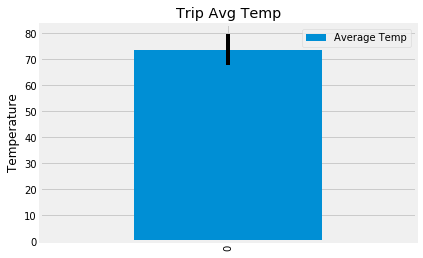

In [38]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

df2 = pd.DataFrame([avg_temp], columns = ['Average Temp'])
fig = df2.plot(kind='bar', yerr=[range_error], title='Trip Avg Temp')
plt.ylabel('Temperature')

# Daily Rainfall Average

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
joined_weather = session.query(Measurement, Station).filter(Measurement.station == Station.station).all()

precipitation = session.query(Station.station, Station.name, Station.elevation, Station.latitude, Station.longitude, func.sum(Measurement.prcp)).\
    filter(Measurement.date >= previous_year_start_date).filter(Measurement.date <= previous_year_end_date).\
    group_by(Station.name).\
    order_by((func.sum(Measurement.prcp)).desc()).all()

print(precipitation)
#df_weather = pd.DataFrame([precipitation])
#df_weather

[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 19.5, 21.33556, -157.71139, 11.500000000000002), ('USC00519397', 'WAIKIKI 717.2, HI US', 3.0, 21.2716, -157.8168, 11.500000000000002), ('USC00519281', 'WAIHEE 837.5, HI US', 32.9, 21.45167, -157.84888999999998, 11.500000000000002), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 306.6, 21.4992, -158.0111, 11.500000000000002), ('USC00517948', 'PEARL CITY, HI US', 11.9, 21.3934, -157.9751, 11.500000000000002), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 152.4, 21.3331, -157.8025, 11.500000000000002), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 7.0, 21.5213, -157.8374, 11.500000000000002), ('USC00513117', 'KANEOHE 838.1, HI US', 14.6, 21.4234, -157.8015, 11.500000000000002), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 0.9, 21.3152, -157.9992, 11.500000000000002)]


In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# Use the start and end date to create a range of dates

vacation_dates = pd.date_range(start_date, end_date)

# Stip off the year and save a list of %m-%d strings

vacation_month_day = vacation_dates.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date
norms=[]

for day in vacation_month_day:
        norms.append(*daily_normals(day))
    
norms

[(67.0, 72.49152542372882, 77.0),
 (65.0, 72.42105263157895, 83.0),
 (64.0, 72.73684210526316, 80.0),
 (66.0, 72.32142857142857, 78.0),
 (65.0, 72.92727272727272, 84.0),
 (65.0, 73.01818181818182, 79.0),
 (67.0, 73.3103448275862, 80.0),
 (66.0, 73.96551724137932, 83.0)]

In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
vaca_norms_df = pd.DataFrame(norms, columns=["tmin","tavg", "tmax"])
vaca_norms_df['date'] = vacation_dates
vaca_norms_df.set_index(["date"],inplace = True)
vaca_norms_df

,tmin,tavg,tmax
date,,,
2017-04-18,67.0,72.491525,77.0
2017-04-19,65.0,72.421053,83.0
2017-04-20,64.0,72.736842,80.0
2017-04-21,66.0,72.321429,78.0
2017-04-22,65.0,72.927273,84.0
2017-04-23,65.0,73.018182,79.0
2017-04-24,67.0,73.310345,80.0
2017-04-25,66.0,73.965517,83.0


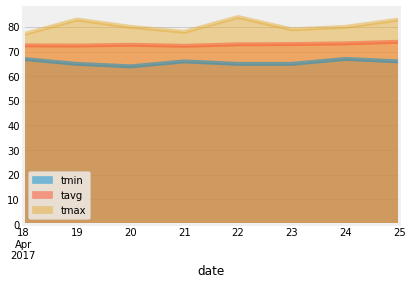

In [33]:
# Plot the daily normals as an area plot with `stacked=False`
ax = vaca_norms_df.plot.area(stacked=False)